In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(img_batch[0])

(32, 256, 256, 3)
[1 0 1 0 1 1 0 0 1 0 1 1 2 1 1 0 1 1 0 1 2 1 0 1 0 0 1 0 0 0 1 1]
tf.Tensor(
[[[140. 136. 150.]
  [144. 140. 154.]
  [147. 143. 157.]
  ...
  [ 92.  84.  97.]
  [ 95.  87. 100.]
  [ 95.  87. 100.]]

 [[145. 141. 155.]
  [143. 139. 153.]
  [141. 137. 151.]
  ...
  [ 95.  87. 100.]
  [ 97.  89. 102.]
  [ 96.  88. 101.]]

 [[145. 141. 155.]
  [141. 137. 151.]
  [136. 132. 146.]
  ...
  [101.  93. 106.]
  [101.  93. 106.]
  [ 98.  90. 103.]]

 ...

 [[131. 125. 137.]
  [133. 127. 139.]
  [135. 129. 141.]
  ...
  [ 91.  83.  94.]
  [ 93.  85.  96.]
  [ 92.  84.  95.]]

 [[130. 124. 136.]
  [132. 126. 138.]
  [135. 129. 141.]
  ...
  [ 91.  83.  94.]
  [ 89.  81.  92.]
  [ 85.  77.  88.]]

 [[131. 125. 137.]
  [132. 126. 138.]
  [134. 128. 140.]
  ...
  [ 87.  79.  90.]
  [ 82.  74.  85.]
  [ 74.  66.  77.]]], shape=(256, 256, 3), dtype=float32)


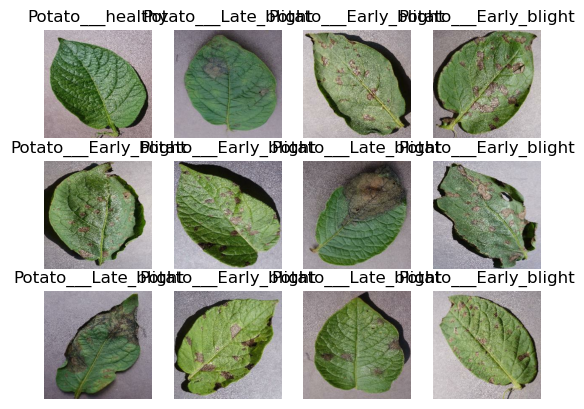

In [8]:
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#  in this we divide the dataset into training, validation and test
#  in the ratio of 80:10:10

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [56]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [22]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [61]:
CHANNELS = 3 
BATCH_SIZE = 32

model = models.Sequential([
#     layers.InputLayer(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale, 
    data_augmentaion, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), 
    layers.Dense(3, activation = 'softmax')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [62]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [64]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data = val_ds
)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_13_1/sequential_11_1/rescaling_1_1/add:0", shape=(None, 256, 256, 3), dtype=float32). Expected shape (256, 256), but input has incompatible shape (None, 256, 256, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=True
  • mask=None